# Imports

In [1]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from datetime import datetime, timedelta

Preprocessing successfully imported.


In [2]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
N = 100000
training_data = preprocessing.read_data(rows_to_read = N)["train"]
print(training_data.columns)
print(len(training_data.columns))

Reading 100000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')
19


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Preprocessing the datetime columns

In [3]:
training_data = preprocessing.parse_datetime_columns(training_data)

### Generating target column "delivery_calendar_days"

In [4]:
training_data = preprocessing.create_delivery_calendar_days(training_data)

In [5]:
training_data["delivery_date"].describe()

/home/swagget/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                  100000
unique                    667
top       2018-12-17 00:00:00
freq                      372
first     2018-01-02 00:00:00
last      2019-12-18 00:00:00
Name: delivery_date, dtype: object

In [6]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 57971
declared_handling_days : 11
acceptance_scan_timestamp : 88902
shipment_method_id : 17
shipping_fee : 1700
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 16089
buyer_zip : 19592
category_id : 33
item_price : 6518
quantity : 28
payment_datetime : 99878
delivery_date : 667
weight : 318
weight_units : 1
package_size : 5
record_number : 100000
delivery_calendar_days : 82


# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [7]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
}

In [8]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (100000, 20)
training_data.shape after :  (100000, 73)


In [9]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics
import math
import numpy as np

In [11]:
# I have tweaked the objective function based on our needs

In [42]:
def customLossFunctionEval(y_true, y_pred):
    residual = (y_true - y_pred).astype(np.float32)
    loss = np.where(residual < 0, -0.6 * (residual), 0.4 * (residual))
    return "Custom Loss Function", np.mean(loss), False

In [75]:
def custom_asymmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float") # Residual is how early it is.
    grad = np.where(residual<0, 2*0.6*residual, -2*0.4*residual)
    hess = np.where(residual<0, 2*0.6, 2*0.4)
    return grad, hess

In [80]:
def custom_symmetric_objective(y_true, y_pred):
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual<0, -2*0.5*residual, -2*0.5*residual)
    hess = np.where(residual<0, 2*0.5, 2*0.5)
    return grad, hess

In [47]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((67000, 62), (33000, 62), (67000,), (33000,))

In [87]:
# I have changed the lr, early_stopping_rounds and n_estimators
model = lgb.LGBMRegressor(learning_rate=0.03,max_depth=-5,random_state=42,early_stopping_rounds = 10,n_estimators=100)
model.set_params(**{'objective': custom_asymmetric_objective})
# model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
#           verbose=10,eval_metric='l2')# This loss needs to mirror the loss that Ebay is using.

LGBMRegressor(early_stopping_rounds=10, learning_rate=0.03, max_depth=-5,
              objective=<function custom_asymmetric_objective at 0x7f1ef292ce60>,
              random_state=42)

In [88]:
model.fit(x_train,y_train,eval_set=[(x_test,y_test)],
          verbose=True,eval_metric=customLossFunctionEval)

[LightGBM] [Warning] early_stopping_round is set=10, early_stopping_rounds=10 will be ignored. Current value: early_stopping_round=10
[1]	valid_0's l2: 29.7675	valid_0's Custom Loss Function: 1.84119
[2]	valid_0's l2: 28.4476	valid_0's Custom Loss Function: 1.78578
[3]	valid_0's l2: 27.2065	valid_0's Custom Loss Function: 1.73204
[4]	valid_0's l2: 26.0384	valid_0's Custom Loss Function: 1.67992
[5]	valid_0's l2: 24.9393	valid_0's Custom Loss Function: 1.62937
[6]	valid_0's l2: 23.9055	valid_0's Custom Loss Function: 1.58037
[7]	valid_0's l2: 22.9323	valid_0's Custom Loss Function: 1.53286
[8]	valid_0's l2: 22.017	valid_0's Custom Loss Function: 1.48683
[9]	valid_0's l2: 21.1562	valid_0's Custom Loss Function: 1.44236
[10]	valid_0's l2: 20.3466	valid_0's Custom Loss Function: 1.39949
[11]	valid_0's l2: 19.5859	valid_0's Custom Loss Function: 1.35798
[12]	valid_0's l2: 18.8688	valid_0's Custom Loss Function: 1.31777
[13]	valid_0's l2: 18.1941	valid_0's Custom Loss Function: 1.27891
[14]	

LGBMRegressor(early_stopping_rounds=10, learning_rate=0.03, max_depth=-5,
              objective=<function custom_asymmetric_objective at 0x7f1ef292ce60>,
              random_state=42)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

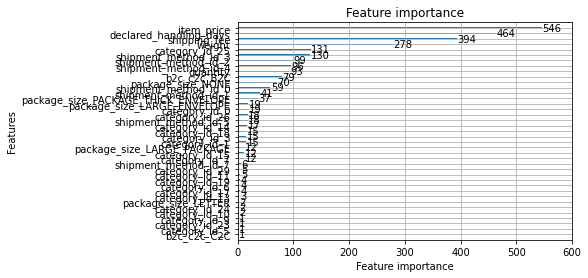

In [30]:
lgb.plot_importance(model)

In [19]:
raise

RuntimeError: No active exception to reraise

## Looking at results

### Checking errors of asymmetric vs symmetric loss function

In [50]:
# Error metrics
y_predicted = model.predict(x_test)
print('MSE', mean_squared_error(y_test, y_predicted))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_predicted)))
print('MAE', mean_absolute_error(y_test, y_predicted))

MSE 8.421695223117316
RMSE 2.9020157172416066
MAE 1.5824572199702986


In [55]:
# Error metrics
print("This is if you make it a custom symmetric function then check all the losses.")
y_predicted = model.predict(x_test)
print('MSE', mean_squared_error(y_test, y_predicted))
print('RMSE', math.sqrt(mean_squared_error(y_test, y_predicted)))
print('MAE', mean_absolute_error(y_test, y_predicted))

This is if you make it a custom symmetric function then check all the losses.
MSE 8.231780701071209
RMSE 2.8691079974569114
MAE 1.5500499008197368


### Checking late vs early predictions

In [56]:
total_under = 0
total_over = 0
perfect = 0
print("This is if you make it a custom symmetric function then check all the errors.\
      This is weird becayse if the massive imbalance. \
      It could possibly be caused because of some outliers skewing the data.")

for pred, actual in zip(y_predicted, y_test):
    if pred<actual:
        total_under += 1
    elif pred>actual:
        total_over += 1
    else:
        perfect += 1
        
print(f"\
total_under = {total_under}\n\
total_over = {total_over}\n\
perfect = {perfect}\n")

This is if you make it a custom symmetric function then check all the errors.      This is weird becayse if the massive imbalance.       It could possibly be caused because of some outliers skewing the data.
total_under = 19896
total_over = 13104
perfect = 0



In [52]:
total_under = 0
total_over = 0
perfect = 0

for pred, actual in zip(y_predicted, y_test):
    if pred<actual:
        total_under += 1
    elif pred>actual:
        total_over += 1
    else:
        perfect += 1
        
print(f"\
total_under = {total_under}\n\
total_over = {total_over}\n\
perfect = {perfect}\n")

total_under = 20089
total_over = 12911
perfect = 0



### Checking number of days expected for delivery

In [89]:
print("Asymmetric predictions")

y_predicted = model.predict(x_test)

arr = np.array(y_predicted)
 
# measures of central tendency
mean = np.mean(arr)
median = np.median(arr)
 
# measures of dispersion
min = np.amin(arr)
max = np.amax(arr)
range = np.ptp(arr)
variance = np.var(arr)
sd = np.std(arr)

print("Descriptive analysis")
print("Array =", arr)
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", min)
print("Maximum =", max)
print("Range =", range)
print("Variance =", variance)
print("Standard Deviation =", sd)

Asymmetric predictions
Descriptive analysis
Array = [3.44823922 3.44823922 4.01848779 ... 4.44194413 3.44823922 3.25639452]
Measures of Central Tendency
Mean = 3.8883363326357143
Median = 3.464285809076717
Measures of Dispersion
Minimum = 3.1875181242946073
Maximum = 30.49046118674647
Range = 27.30294306245186
Variance = 0.9542340793237508
Standard Deviation = 0.9768490565710501


In [86]:
print("Symmetric predictions")

y_predicted = model.predict(x_test)

arr = np.array(y_predicted)
 
# measures of central tendency
mean = np.mean(arr)
median = np.median(arr)
 
# measures of dispersion
min = np.amin(arr)
max = np.amax(arr)
range = np.ptp(arr)
variance = np.var(arr)
sd = np.std(arr)

print("Descriptive analysis")
print("Array =", arr)
print("Measures of Central Tendency")
print("Mean =", mean)
print("Median =", median)
print("Measures of Dispersion")
print("Minimum =", min)
print("Maximum =", max)
print("Range =", range)
print("Variance =", variance)
print("Standard Deviation =", sd)

Symmetric predictions
Descriptive analysis
Array = [3.50317847 3.50317847 4.07389572 ... 4.34149269 3.50317847 3.33955577]
Measures of Central Tendency
Mean = 3.9248233068462843
Median = 3.5658271867125335
Measures of Dispersion
Minimum = 3.2444972590816703
Maximum = 27.8005522729951
Range = 24.55605501391343
Variance = 0.784123764666048
Standard Deviation = 0.8855076310603134


In [ ]:
y_predicted

In [ ]:
y_test

In [ ]:
raise

In [ ]:
from sklearn.datasets import make_friedman2, make_friedman1, make_regression

In [ ]:
X1, Y1 = make_friedman1(n_samples=1000, n_features=7, noise=0.0, random_state=11)
y_true = Y1
y_pred = np.linspace(-100,100,1000)
grad, hess = custom_asymmetric_objective(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

In [ ]:
X1, Y1 = make_friedman1(n_samples=1000, n_features=7, noise=0.0, random_state=11)
y_true = Y1
y_pred = np.linspace(-100,100,1000)
# y_pred = model.predict(x)
grad, hess = customLossFunctionTrain(y_true, y_pred)

fig, ax = plt.subplots(1,1, figsize=(8,4))

# ax.plot(y_hat, errors)
ax.plot(y_pred, grad)
ax.plot(y_pred, hess)
ax.legend(('gradient', 'hessian'))
ax.set_xlabel('Predictions')
ax.set_ylabel('first or second derivates')

fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(y_true, y_pred)
ax.set_xlabel('actual')
ax.set_ylabel('predicted')
ax.legend(('true', 'false'))
# fig.tight_layout()

In [ ]:
y_true[:10], y_pred[:10]

In [ ]:
raise

In [ ]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [ ]:
del training_data

In [ ]:
quiz_data = preprocessing.read_data(rows_to_read = N)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


In [ ]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

In [ ]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [ ]:
output_columns_name = "predicted_delivery_date"

In [ ]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [ ]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [ ]:
import pandas as pd

In [ ]:
submission = pd.read_csv("./results/result_2021-12-19 16:59:16.tsv", sep='\t', header = None)

In [ ]:
submission